## learning-AI : deep learning application (61357002)
### assignment : denoising AE about HAR DSADS

**DSADS 데이터셋을 이용하여 denoising AE를 구현**

<br>

- **임규연 (lky473736)**
- 2024.10.17.에 문서 작성

## <span id='dl'><mark>DL</mark></span>
    
**DSA 데이터에서 lyingRigh과 lyingBack의 정상 데이터(각각 480개)를 사용하고, standingInElevatorStill 활동을 비정상 데이터로 설정**한다. 두 가지 활동(lying과 standingInElevatorStill)을 섞어서 데이터를 구성한 후, **lying 데이터만 사용하여 오토인코더를 학습**한다. 이후, 혼합된 테스트 데이터(lying+standingInElevatorStill)를 AE에 입력하여 **reconstruction error**(입력과 출력의 차이)를 계산한다. 적절한 임계값(threshold)을 설정하여 분류를 수행한 뒤, 모델의 정확도(accuracy)를 평가한다.

denosing AE를 구현한다. denoising AE는 noise가 섞인 데이터를 깨끗히 정제하기 위한 모델이다.

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

2024-10-29 00:24:51.478422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


---

### 1. 탐색적 데이터 분석 및 데이터 전처리 수행
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.

In [3]:
# 데이터 로드

df = pd.read_csv('../../data/DSA_features.csv')
# df = pd.read_csv('../dataset/ae_data.csv')

df.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [4]:
# 데이터의 정보 및 기초통계량 확인

df.info() 
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


,count,mean,std,min,25%,50%,75%,max
T_xacc_mean,9120.0,7.765766,3.758022,-1.157566e+01,8.374161,9.186328,9.515573,10.713139
T_xacc_max,9120.0,14.625536,11.823448,-4.758700e+00,9.523200,12.549500,15.843250,93.694000
T_xacc_min,9120.0,3.602974,5.622855,-9.971500e+01,0.000000,5.757900,7.649075,9.749000
T_xacc_var,9120.0,17.807013,45.188787,1.353291e-04,0.036855,2.241468,6.680571,392.898630
T_xacc_std,9120.0,2.454290,3.432895,1.163310e-02,0.191977,1.497153,2.584680,19.821671
...,...,...,...,...,...,...,...,...
LL_zmag_max,9120.0,0.169687,0.360190,-9.108300e-01,-0.035821,0.210825,0.422270,1.042600
LL_zmag_min,9120.0,-0.052866,0.359712,-1.126000e+00,-0.326125,-0.040447,0.206933,0.999440
LL_zmag_var,9120.0,0.007625,0.019034,2.960874e-07,0.000223,0.001814,0.006928,0.279020
LL_zmag_std,9120.0,0.059342,0.064059,5.441392e-04,0.014925,0.042586,0.083234,0.528223


In [5]:
# 결측치 확인

'''
    결측치 없음을 확인 가능
'''

print (df.isnull().sum()) 
print (any(df.isnull().sum())) # False로 나왔으니 결측치가 없는 것임

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64
False


In [6]:
# class 종류 확인

print (f"class 종류 :  {np.unique(df['activity'])}")

class 종류 :  ['ascendingStairs' 'basketBall' 'crossTrainer' 'cyclingHorizontal'
 'cyclingVertical' 'decendingStairs' 'jumping' 'lyingBack' 'lyingRigh'
 'movingInElevator' 'rowing' 'runningTreadmill' 'sitting' 'standing'
 'standingInElevatorStill' 'stepper' 'walkingLot' 'walkingTreadmillFlat'
 'walkingTreadmillIncline']


In [7]:
# 3가지 행동추출 (lyingRigh, lyingBack, standingInElevatorStill)

df = df.loc[df['activity'].isin(['lyingRigh', 'lyingBack', 'standingInElevatorStill'])]
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.417440,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.403720,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.426160,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.308770,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.389000,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9.802530,9.8423,9.6857,0.000865,0.029403,-1.341638,-0.185503,-0.090833,-0.25891,0.001316,...,0.006399,-0.962316,0.488304,0.51448,0.46222,5.126574e-05,0.007160,-0.717994,standingInElevatorStill,p8
3356,9.799047,9.9038,9.7250,0.000750,0.027379,0.468885,-0.200147,-0.113400,-0.29976,0.001781,...,0.006276,-0.513505,0.488314,0.51509,0.46554,4.488257e-05,0.006699,0.136985,standingInElevatorStill,p8
3357,9.797938,9.8537,9.7347,0.000576,0.023998,-0.365021,-0.195523,-0.132300,-0.25615,0.001006,...,0.005879,0.691562,0.486659,0.51104,0.46926,4.251657e-05,0.006520,0.178792,standingInElevatorStill,p8
3358,9.606040,9.9302,9.1379,0.067806,0.260396,-0.719145,-0.188162,-0.119480,-0.25154,0.000760,...,0.007984,-0.736630,0.490615,0.53319,0.46602,8.602620e-05,0.009275,1.175198,standingInElevatorStill,p8


activity
lyingBack                  480
lyingRigh                  480
standingInElevatorStill    480
Name: count, dtype: int64


<Axes: xlabel='activity', ylabel='count'>

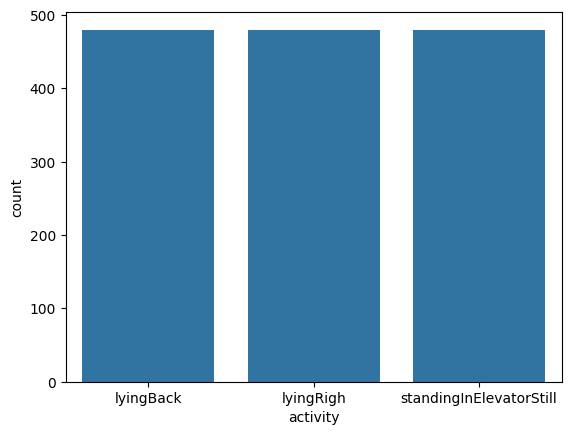

In [8]:
# target countplot

print (df['activity'].value_counts())
sns.countplot(x='activity', data=df)

In [9]:
# df에서 people 열 제거

df = df.drop('people', axis=1)

In [10]:
# what 열을 수정
# standingInElevatorStill abnormal, lyingRigh이나 lyingBack은 normal

df['what'] = df['activity'].map({
    'standingInElevatorStill': 'abnormal',
    'lyingRigh': 'normal',
    'lyingBack': 'normal'
})

df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,what
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.417440,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,normal
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.403720,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,normal
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.426160,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,normal
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.308770,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,normal
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.389000,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9.802530,9.8423,9.6857,0.000865,0.029403,-1.341638,-0.185503,-0.090833,-0.25891,0.001316,...,0.006399,-0.962316,0.488304,0.51448,0.46222,5.126574e-05,0.007160,-0.717994,standingInElevatorStill,abnormal
3356,9.799047,9.9038,9.7250,0.000750,0.027379,0.468885,-0.200147,-0.113400,-0.29976,0.001781,...,0.006276,-0.513505,0.488314,0.51509,0.46554,4.488257e-05,0.006699,0.136985,standingInElevatorStill,abnormal
3357,9.797938,9.8537,9.7347,0.000576,0.023998,-0.365021,-0.195523,-0.132300,-0.25615,0.001006,...,0.005879,0.691562,0.486659,0.51104,0.46926,4.251657e-05,0.006520,0.178792,standingInElevatorStill,abnormal
3358,9.606040,9.9302,9.1379,0.067806,0.260396,-0.719145,-0.188162,-0.119480,-0.25154,0.000760,...,0.007984,-0.736630,0.490615,0.53319,0.46602,8.602620e-05,0.009275,1.175198,standingInElevatorStill,abnormal


In [11]:
# df에서 activity 열 제거

df = df.drop('activity', axis=1)

In [12]:
# normal과 abnormal dataset을 구성, train set, test set 구성

abnormal = df[df.what == 'abnormal'] 
normal = df[df.what == 'normal']
 
train = normal.copy() # train data (normal만 학습시킴)
test = pd.concat([normal, abnormal])  # 합치기

train.shape, test.shape

((960, 271), (1440, 271))

<Axes: xlabel='what', ylabel='count'>

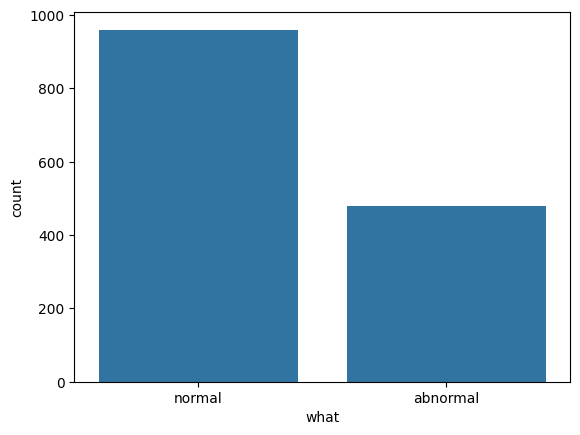

In [13]:
# normal과 abnormal 갯수 countplot

sns.countplot(x='what', data=df)

In [14]:
# normal을 0, abnormal을 1로 만들기

# train 데이터프레임에서 'what' 열 수정
train['what'] = 0 # 어차피 모든 열이 다 normal임

print (any(train['what'] == 1)) # false가 나오는게 정상임

# test 데이터프레임에서 'what' 열 수정
test['what'] = test['what'].map({
    'normal': 0,
    'abnormal': 1
})

print (train['what'].unique())
print (test['what'].unique())

False
[0]
[0 1]


In [15]:
# input, target split

y_train, X_train = train['what'], train.drop('what', axis=1)
y_test, X_test = test['what'], test.drop('what', axis=1)

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (y_train.unique(), y_test.unique())

(960, 270) (960,) (1440, 270) (1440,)
[0] [0 1]


In [16]:
# z-score normalization

from sklearn.preprocessing import StandardScaler

normalizier = StandardScaler()
X_train_scaled = normalizier.fit_transform(X_train)
X_test_scaled = normalizier.transform(X_test)

In [17]:
# noising 추가

def add_noise(data, noise_factor=0.5) :
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noisy_data = data + noise
    return np.clip(noisy_data, -1, 1) # scaling

X_train_noisy = add_noise(X_train_scaled) # normal만 들어있는 것임
X_test_noisy = add_noise(X_test_scaled) 

print (X_train_noisy.shape, X_test_noisy.shape)

(960, 270) (1440, 270)


------

### 2. AE 구성 및 denoising-AE를 위한 학습

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        34,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 270)            │        17,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,030 (257.93 KB)

 Trainable params: 66,030 (257.93 KB)

 Non-trainable params: 0 (0.00 B)

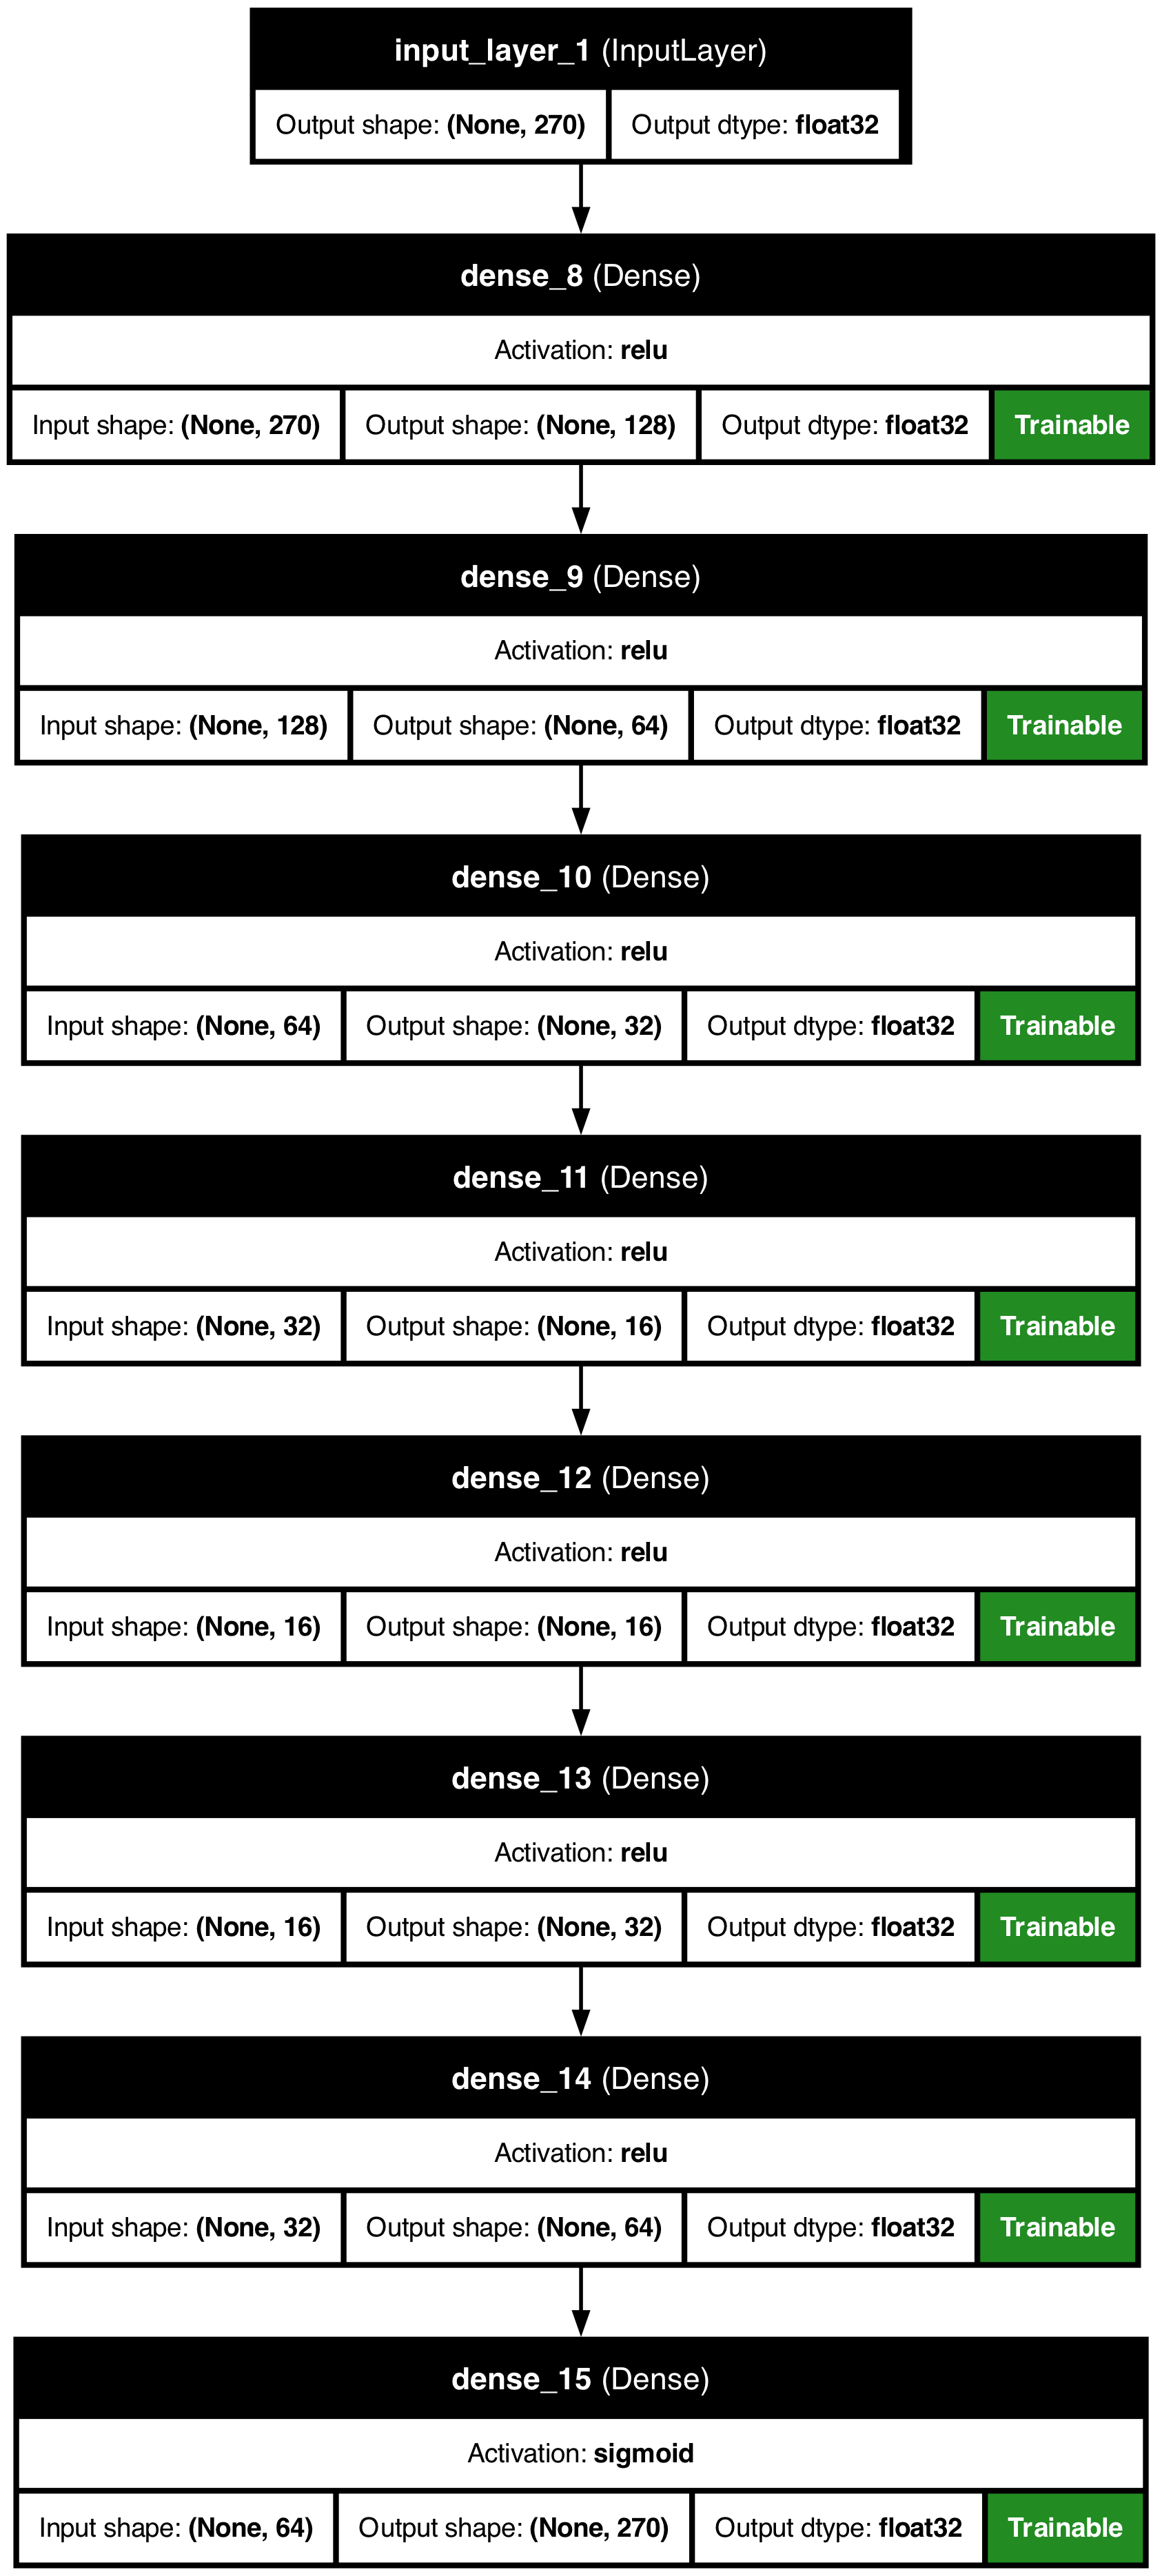

In [25]:
# modeling (linear-AE로 구성)

from tensorflow.keras.layers import Input
from tensorflow.keras import Model

input_dim = X_train_noisy.shape[1]  # feature의 갯수임
encoding_dim = 128

input_layer = Input(shape=(input_dim,))

# encoding 단계
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)
encoded = Dense(encoding_dim // 8, activation='relu')(encoded)

# decoding 단계
decoded = Dense(encoding_dim // 8, activation='relu')(encoded)
decoded = Dense(encoding_dim // 4, activation='relu')(decoded)
decoded = Dense(encoding_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, show_dtype=True,
                         show_layer_activations=True,
                         show_layer_names=True,
                         show_shapes=True,
                         show_trainable=True)

In [26]:
# compile

autoencoder.compile(optimizer='adam', loss='mse')

In [27]:
# fit

history = autoencoder.fit (X_train_noisy, X_train, 
                          validation_data=(X_test_noisy, X_test),
                          epochs=50,
                          batch_size=64)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.6961 - val_loss: 5.5917
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5150 - val_loss: 5.1719
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0230 - val_loss: 5.1299
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0444 - val_loss: 5.1185
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0835 - val_loss: 5.1078
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9833 - val_loss: 5.0771
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9503 - val_loss: 5.0703
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9381 - val_loss: 5.0646
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8876 - val_loss: 5.0578
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8907 - val_loss: 5.0563
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0263 - val_loss: 5.0556
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8948 - val_l

{'loss': [5.701020240783691, 5.291581153869629, 5.047152996063232, 5.028547763824463, 5.008152484893799, 4.979501247406006, 4.959385871887207, 4.951608180999756, 4.942044258117676, 4.9393086433410645, 4.938887119293213, 4.9386887550354, 4.938387870788574, 4.93820333480835, 4.937901020050049, 4.937501430511475, 4.937073707580566, 4.936526775360107, 4.9359869956970215, 4.9356536865234375, 4.935452461242676, 4.934360980987549, 4.929996967315674, 4.923556327819824, 4.9223175048828125, 4.921173095703125, 4.920629978179932, 4.919239521026611, 4.916797161102295, 4.913568019866943, 4.912440299987793, 4.9117751121521, 4.911074638366699, 4.9100542068481445, 4.909695625305176, 4.909425735473633, 4.908586502075195, 4.908010005950928, 4.907631874084473, 4.907368183135986, 4.907183647155762, 4.907105445861816, 4.906985759735107, 4.9068450927734375, 4.906704902648926, 4.906460285186768, 4.906399250030518, 4.906227111816406, 4.906228542327881, 4.9061174392700195], 'val_loss': [5.591700077056885, 5.171

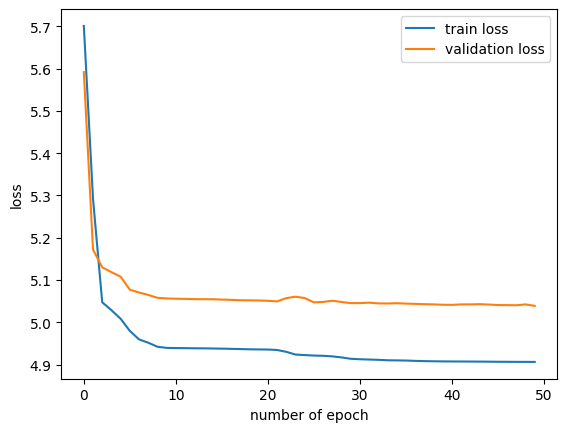

'\n    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.\n'

In [29]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

'''
    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.
'''

In [30]:
# reconstruction error 

predictions = autoencoder.predict(X_test_noisy) 
reconstruction_error = np.mean(np.square(X_test_scaled - predictions), axis=1) # mse

error_df_linear = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'true_class': y_test
})

'''
    reconstruction error가 높다 -> fraud일 가능성이 매우 높아지는 것 
    (실제 정상인 데이터를 가지고 모델을 학습시켰으니 이상한 값에 대하여 loss가 많을 것)
'''

error_summary = error_df_linear.describe()
error_summary

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,reconstruction_error,true_class
count,1440.000000,1440.000000
mean,131.809700,0.333333
std,545.645005,0.471568
min,0.209811,0.000000
25%,0.462816,0.000000
50%,0.655376,0.000000
75%,3.991590,1.000000
max,6222.373822,1.000000


In [31]:
# 임계값 설정

mean_error = error_df_linear['reconstruction_error'].mean()
std_error = error_df_linear['reconstruction_error'].std()

k = 2
threshold = 1
# (mean_error + k * std_error) 

print (threshold)

1


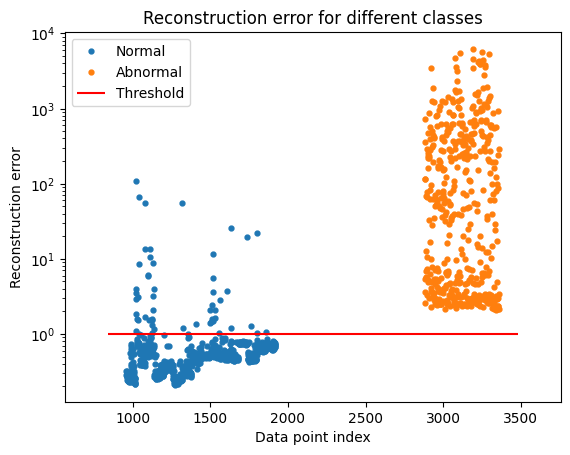

In [32]:
# reconstruction error visualization

import math

groups = error_df_linear.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups :
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
ax.set_yscale('log')
ax.hlines(math.log(threshold), ax.get_xlim()[0], ax.get_xlim()[1], colors="b", zorder=100, label='Threshold')

plt.show();

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       960
           1       0.90      1.00      0.95       480

    accuracy                           0.96      1440
   macro avg       0.95      0.97      0.96      1440
weighted avg       0.97      0.96      0.96      1440



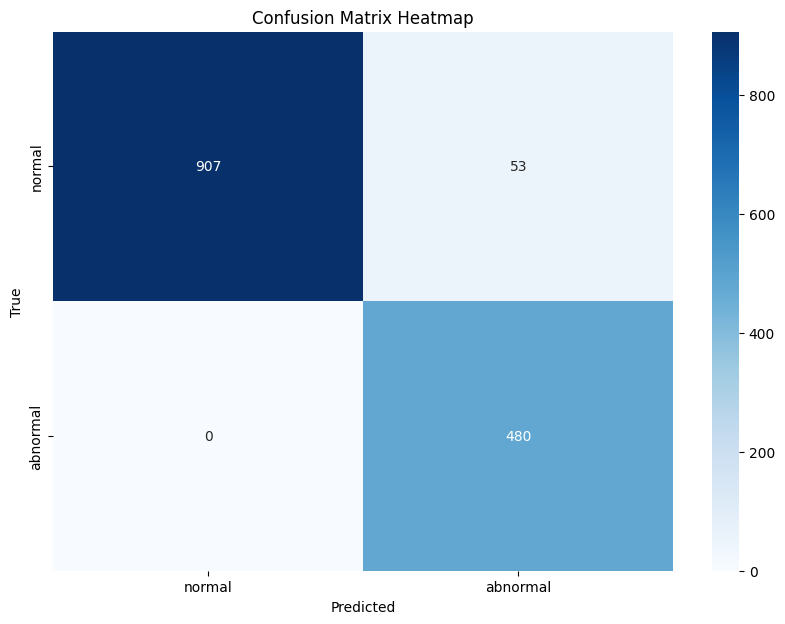

In [33]:
# classification report, heatmap

from sklearn.metrics import confusion_matrix, classification_report

error_df_linear['predicted_class'] = (error_df_linear['reconstruction_error'] > threshold).astype(int)
print(classification_report(error_df_linear['true_class'], error_df_linear['predicted_class']))

cm_linear = confusion_matrix(error_df_linear['true_class'], error_df_linear['predicted_class'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'abnormal'], 
            yticklabels=['normal', 'abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()